# 1.import modules

In [40]:
import os
from scipy import io

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import pandas as pd

In [41]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# 2.Data processing

## 2.1 `*.mat` file 불러오기

In [42]:
dataDir = 'data/'
rawDir = dataDir + 'raw/'

file_list = os.listdir(rawDir)
print(file_list)

['V1_JIAT_RealRoad_T011.mat', 'V1_JIAT_RealRoad_T012.mat', 'V1_JIAT_RealRoad_T013.mat', 'V1_JIAT_RealRoad_T014.mat', 'V1_JIAT_RealRoad_T015.mat']


In [43]:
mat_list = []
for i, file_name in enumerate(file_list):
  mat_name = 'mat_{}'.format(i)
  mat_list.append(mat_name)
  globals()[f"{mat_name}"]=io.loadmat(rawDir+file_name)

In [44]:
print(mat_list)
# print(globals()[mat_list[0]].keys())

['mat_0', 'mat_1', 'mat_2', 'mat_3', 'mat_4']


## 2.2 resampling

In [45]:
a_des = 'Veh_Ctrl__DesiredAcceleration__________________________________'
Vx ='VCU1_LRR__vcuLrr_VEHICLE_SPEED_________________________________'
a_sen = 'Acceleration_Info2__Veh_Acc_Xaxis______________________________'
SWA_des = 'Veh_Ctrl__DesiredSteerAngle____________________________________'

data_name_list = ['a_des', 'Vx', 'a_sen']
data_list = [globals()[name] for name in data_name_list]
print(data_list)

['Veh_Ctrl__DesiredAcceleration__________________________________', 'VCU1_LRR__vcuLrr_VEHICLE_SPEED_________________________________', 'Acceleration_Info2__Veh_Acc_Xaxis______________________________']


In [46]:
mat_dfs = pd.DataFrame()
for mat_name in mat_list:
  mat = globals()[mat_name]

  mat_df = pd.DataFrame()
  
  for j, data_name in enumerate(data_list):
    data = mat[data_name]
    df = pd.DataFrame(data[:,1], index=data[:,0])
    df.columns = [data_name_list[j]]
    df.index = pd.to_datetime(df.index, unit='s')
    
    df = df.resample('10ms').last().fillna(method='ffill')
    if data_name_list[j] == 'a_sen':
      df['a_sen'] = df['a_sen']*9.81

    # df = df.fillna(0)

    mat_df = pd.concat([mat_df, df], axis=1).fillna(0)
  break
  # mat_dfs = pd.concat([mat_dfs, mat_df], axis=0, ignore_index=True)

In [47]:
mat_df

,a_des,Vx,a_sen
1970-01-01 00:00:00.010,0.28,0.0,-0.819865
1970-01-01 00:00:00.020,0.28,0.0,-0.819865
1970-01-01 00:00:00.030,0.27,0.0,-0.788620
1970-01-01 00:00:00.040,0.27,0.0,-0.788620
1970-01-01 00:00:00.050,0.27,0.0,-0.416181
...,...,...,...
1970-01-01 00:01:32.230,0.25,0.0,0.413682
1970-01-01 00:01:32.240,0.25,0.0,0.416181
1970-01-01 00:01:32.250,0.25,0.0,0.392435
1970-01-01 00:01:32.260,0.25,0.0,0.417431


### 데이터 확인 (plot)

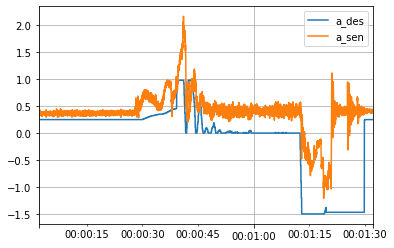

In [48]:
# plt.figure(figsize=(12,12))
fig = mat_df[['a_des', 'a_sen']][200:].plot()
plt.grid(True)
plt.show()

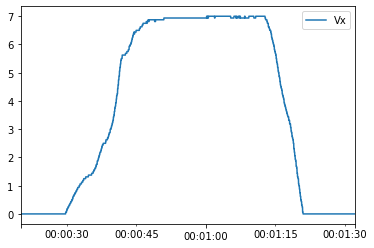

In [49]:
mat_df[['Vx']][2000:].plot()
plt.show()

In [50]:
data = mat_df[['Vx','a_sen','a_des']][200:].values # 앞 부분은 잘라냄.

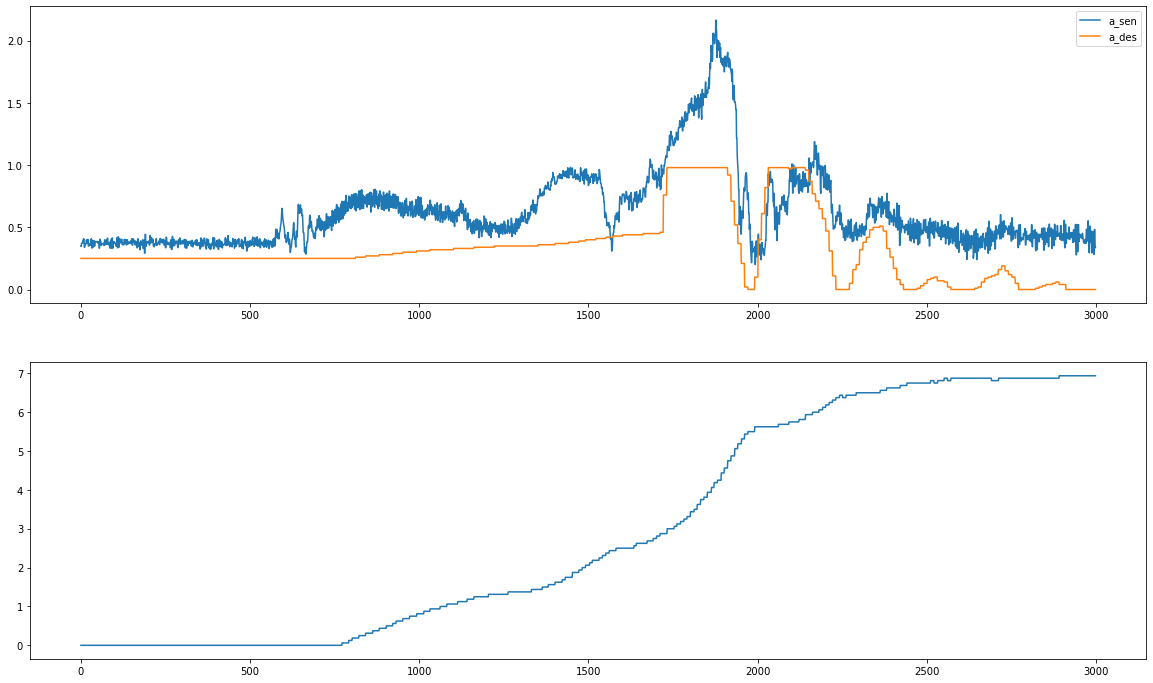

In [92]:
start= 2000
viewStep = 3000
diffStep = 30 # 20~30 step 보면 될듯?
plt.figure(figsize=(20,12))
plt.subplot(2,1,1)
plt.plot(data[start+diffStep:start+viewStep+diffStep,1], label='a_sen')
plt.plot(data[start:start+viewStep:,2], label='a_des')
plt.legend()
plt.subplot(2,1,2)
plt.plot(data[start:start+viewStep:,0])
plt.show()

이 단계에서 norma

### 2.2.2 data 저장

In [51]:
prcsDir = dataDir + 'resampled/'

try:
  if not os.path.exists(prcsDir):
    os.makedirs(prcsDir)
except OSError:
  print('Error: Creating directory. '+ prcsDir)

## 2.3 sequence

In [52]:
print(data.shape)
print(len(data))

(9027, 3)
9027


In [53]:
n = 20
m = 20

In [54]:
def makeSequence(data, inSeq_len, outSeq_len):
  Xs = []
  Ys = []
  for i in range(len(data) + 1 - (inSeq_len+outSeq_len)):
    x = data[i:i+inSeq_len]
    y = data[i+inSeq_len: i+inSeq_len+outSeq_len,1]

    Xs.append(x)
    Ys.append(y)

  Xs = np.array(Xs).reshape(len(Xs), inSeq_len, -1)
  Ys = np.array(Ys).reshape(len(Xs), inSeq_len, -1)

  return Xs, Ys

In [55]:
Xs, Ys = makeSequence(data, n, m)
print(Xs.shape)
print(Ys.shape)

(8988, 20, 3)
(8988, 20, 1)


## 2.4 data split

In [56]:
train_data_num = int(len(data)*0.8)
print(train_data_num)
trainX = Xs[:train_data_num]
trainY = Ys[:train_data_num]
testX = Xs[:train_data_num]
testY = Ys[:train_data_num]

print(trainX.shape)

7221
(7221, 20, 3)


# 3.Model define


embedding이 필요 없을 것으로 판단.

In [57]:
class RNN(nn.Module):
  def __init__(self, input_dim=3, hidden_dim=32, target_dim=1):
    super().__init__()
    self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, batch_first=True)
    self.hidden2pred = nn.Linear(hidden_dim, target_dim)

  def forward(self, x):
    lstm_out, _ = self.lstm(x)
    net_out = self.hidden2pred(lstm_out)
    
    return net_out

net = RNN().to(device)

In [58]:
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(0.5, 0.999))

# 4.training

In [59]:
trainX = torch.Tensor(trainX)
trainY = torch.Tensor(trainY)
testX = torch.Tensor(testX)
testY = torch.Tensor(testY)

In [60]:
epochs = 30
batch_size = 16
disp_rate = 100
losses = []
for epoch in range(epochs):
  running_loss = 0.0
  for j in range(0, len(trainX), batch_size):
    trainX_in = trainX[j:j+batch_size]
    trainY_in = trainY[j:j+batch_size]

    inputs, labels = trainX_in.to(device), trainY_in.to(device) 

    optimizer.zero_grad()
    
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    losses.append(loss)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    if j % disp_rate == disp_rate-1:
      print(f"epochs: {epoch+1:3}, batches: {j+1:6}, loss: {running_loss/disp_rate:.3f}")
      running_loss = 0.0

print('Finished training')


Finished training


# 5. model 저장 및 불러오기

In [61]:
PATH = './models/test.pth'
torch.save(net.state_dict(), PATH)

In [62]:
net = RNN()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

# 6.결과 확인

In [63]:
outputs = net(testX)


In [64]:
trueY_cpu = testY.numpy()

outputs_cpu = outputs.to("cpu")
outputs_np = outputs_cpu.detach().numpy()
print(outputs_np.shape)

(7221, 20, 1)


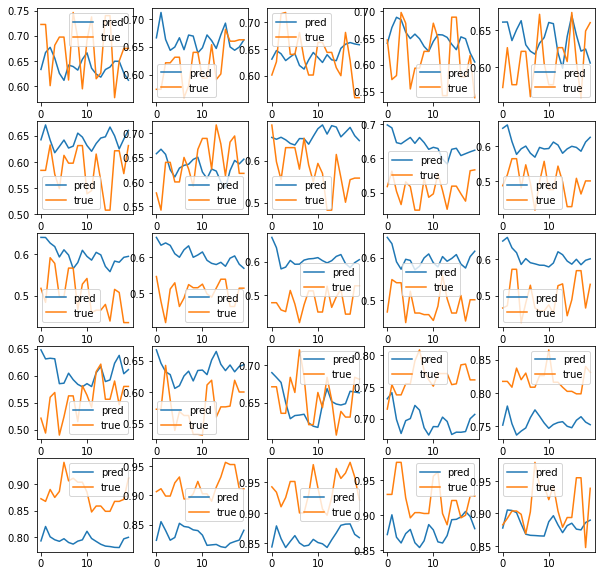

In [65]:
plt.figure(figsize=(10,10))
for i in range(5):
  for j in range(5):
    plt.subplot(5, 5, 5*i + j + 1)
    plt.plot(outputs_np[(5*i + j)*20+3000], label='pred')
    plt.plot(trueY_cpu[(5*i + j)*20+3000], label='true')
    plt.legend()

plt.show()

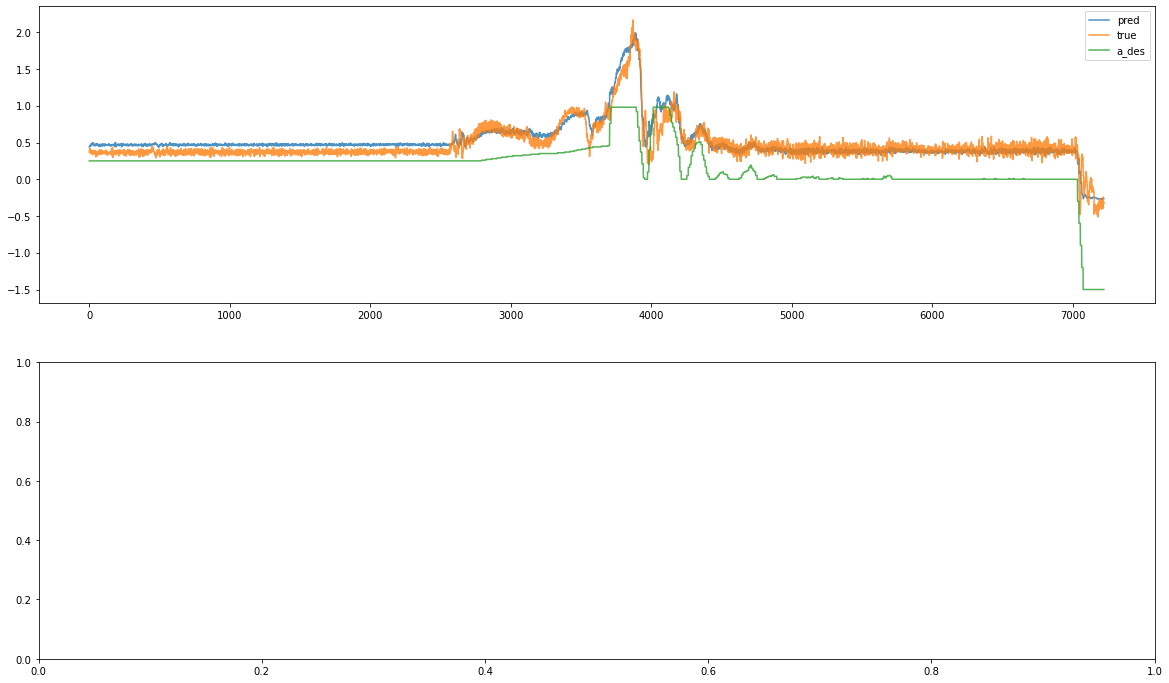

In [72]:
predStep = 19 # 0~19
plt.figure(figsize=(20,12))
plt.subplot(2,1,1)
plt.plot(outputs_np[:,predStep], label='pred', alpha = 0.8)
plt.plot(trueY_cpu[:,predStep], label='true', alpha = 0.8)
plt.plot(testX.numpy()[:,-1,2], label='a_des', alpha = 0.8)

plt.legend()

plt.subplot(2,1,2)

plt.show()


In [67]:
print(outputs_np.shape)
print(trueY_cpu.shape)
print(testX.numpy().shape)

(7221, 20, 1)
(7221, 20, 1)
(7221, 20, 3)
